# LSTM 기반으로 Script를 생성하는 모델 만들기

In [1]:
import os
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm
from tqdm import trange
from tensorflow.python.ops.rnn_cell_impl import RNNCell
from collections import Counter, namedtuple

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### LSTM Cell 을 정의합니다

In [2]:
class LstmStates(
    namedtuple("LstmStates", ("c_state", "h_state"))):
    pass

class MyLSTMCell(RNNCell):
    
    def __init__(self, num_units, name):
        super(MyLSTMCell, self).__init__(name=name)
        self.num_units = num_units
        self._custom_name = name
    
    def zero_state(self, batch_size, dtype=tf.float32):
        state = tf.tile(tf.zeros([1, self.num_units]), [batch_size, 1])        
        return LstmStates(state, state)

    def __call__(self, x, state):
        with tf.variable_scope(self._custom_name, reuse=tf.AUTO_REUSE):
            c, h = state
            
            inputs = tf.concat([x, h], axis=-1)            
            
            f_gate = tf.layers.dense(inputs, self.num_units, activation=tf.nn.sigmoid, use_bias=True, name='forget_gate')
            i_gate = tf.layers.dense(inputs, self.num_units, activation=tf.nn.sigmoid, use_bias=True, name='input_gate')            
            o_gate = tf.layers.dense(inputs, self.num_units, activation=tf.nn.sigmoid, use_bias=True, name='output_gate')
            g_gate = tf.layers.dense(inputs, self.num_units, activation=tf.nn.tanh, use_bias=True, name='gain_gate')
                        
            new_c = f_gate * c + i_gate * g_gate
            new_h = o_gate * tf.nn.tanh(new_c)
                        
            return new_h, LstmStates(new_c, new_h)
        
    @property
    def state_size(self):
        return LstmStates(self.num_units, self.num_units)

    @property
    def output_size(self):
        return self.num_units

In [3]:
def read_txt():
    data = ""
    for text in glob('./Tozi/*.txt'):
        with open(text, 'r', encoding='euc-kr', errors='ignore') as f:
            data += f.read().strip()
    return data.split('\n')

###  데이터를 읽습니다.

In [4]:
data = read_txt()

In [5]:
for line in data[1500:1510]:
    print(line)

"옷이 날개라 카더마는 채리고 나서리 제법 사람 같고나."
옷발이야 굵겠지만 명색이 모시라, 모시 중의 적삼을 입고 대님을  치고 흰 고무신에다 생고사 조끼까지 입은 
귀남애비는 어디로 가는지 두 활개를 치며 걸어 내려가는 것이었다. 그의 모습아 시야에서 사라지자 천일어매
가 말했다.
"죽은 우리 천일아배도 그런 말을 들었다마는 귀남애비 저 사람도 소다 소.  이마에 소 우 짜 붙이고 사는 사
람이다."
"그래도 성자할무이가 잘했이니 동네서 인심은 안 잃었제요."
"내가 머 잘한 것도 없다마는 하도 남정네가 말썽을 피고 댕긴께 감당은 내가 해야지 우짤 기고, 밖에서 미련
하믄 안에서 사지역지해야, 자식 키우는 사람이 남의 입질에 오리내리는 것도 좋지 않제."
역지사지를 반대로 말한 것이나 처지를 바꾸어 생각하는, 즉 이해한다는 뜻힌데 위에 오르고 아래로 내려왔다 


### 간단한 데이터 분석을 진행합니다

In [6]:
len(data)

160451

In [7]:
minimum_freq = 500

cnt = Counter([char for line in read_txt() for char in line])
stop_words = [char for char, freq in cnt.items() if freq < minimum_freq]
use_words = sorted([item for item, _ in cnt.items() if item not in stop_words])

In [8]:
print(cnt.most_common()[:100])

[(' ', 1135877), ('.', 156711), ('이', 150460), ('다', 120302), ('"', 117405), ('는', 103507), ('고', 70267), ('가', 68953), ('을', 67224), ('지', 62315), ('하', 60222), ('그', 59021), ('에', 57039), ('아', 53121), ('은', 50688), ('어', 48442), ('서', 46867), ('나', 44606), (',', 44043), ('도', 42444), ('기', 36861), ('한', 35083), ('의', 35037), ('리', 34771), ('니', 34273), ('사', 31110), ('었', 29664), ('라', 28472), ('것', 28359), ('들', 28080), ('를', 27975), ('로', 27215), ('있', 25801), ('자', 25666), ('?', 25418), ('으', 23930), ('말', 23085), ('게', 22836), ('만', 21739), ('일', 21496), ('요', 21108), ('인', 20144), ('시', 19658), ('마', 19456), ('소', 18516), ('보', 18164), ('내', 17572), ('오', 17251), ('수', 17241), ('없', 17025), ('거', 16330), ('해', 16195), ('했', 15972), ('상', 15444), ('러', 15251), ('까', 14724), ('부', 14691), ('면', 14471), ('여', 14335), ('무', 14202), ('야', 14136), ('모', 13800), ('생', 13734), ('구', 13412), ('데', 13375), ('대', 12852), ('주', 12780), ('안', 12689), ('신', 11860), ('우', 11391), ('장', 11243)

In [9]:
print(stop_words[:150])

['4', '솔', '례', '7', '8', '9', '류', '0', '5', '6', '페', '뇌', '얀', '햇', '탁', 'ㅣ', '찰', '팽', '쾅', '즐', '엿', '귓', '꼭', '츰', '휩', '징', '켰', '뽑', '핏', '퓨', '넌', '쨌', '쎄', 'd', 'l', 't', 'k', 'g', 'r', 's', '겐', '혁', '맣', '압', '꽂', '힐', '룻', '벅', '떼', '북', '혐', '놨', '효', '셈', '꿎', '겪', '덮', '멸', '잽', '푹', '짤', '턱', '삿', '빤', '빼', '앗', '꿍', '앓', '땀', '뽀', '잇', '잤', '괘', '씸', '놔', '낳', '쏟', '죠', '짊', '뉘', '웬', '맏', '특', '굳', '짇', '틈', '녹', '싱', '꽤', '룬', '롸', 'G', '념', '퇴', '닫', '칭', '썰', '젤', '섧', '깎', '뻬', '앵', '텀', '깡', '찼', '꼍', '쬐', '짚', '탕', '릿', '헹', '펜', '덤', '협', '냈', '봤', '콱', '푼', '탓', '珦', '꼈', '썼', '짖', '닙', '케', '볶', '끗', '븐', '깃', '벼', '룩', '똥', '빰', '짱', '닦', '춘', '깜', '씩', '…', '쿠', '샛', '밉', '콩', '팥', '끈', '흩', '묶', '껏', '돋', '썩']


In [10]:
print(use_words[:150])

[' ', '!', '"', "'", '(', ')', ',', '.', '1', '2', '3', ':', '?', '“', '”', '가', '각', '간', '갈', '감', '갑', '갔', '강', '갖', '같', '개', '객', '거', '걱', '건', '걷', '걸', '겁', '것', '겄', '겉', '게', '겠', '겨', '격', '견', '결', '경', '계', '고', '곡', '곤', '골', '곳', '공', '과', '관', '광', '괴', '교', '구', '국', '군', '굴', '권', '귀', '그', '극', '근', '글', '금', '급', '기', '긴', '길', '김', '깊', '까', '깔', '깨', '꺼', '께', '꼬', '꼴', '꾸', '꾼', '꿈', '끄', '끌', '끔', '끝', '끼', '낀', '나', '낙', '난', '날', '남', '났', '낮', '내', '낸', '냐', '냥', '너', '넘', '넣', '네', '녀', '녁', '년', '노', '놀', '놈', '농', '놓', '누', '눈', '느', '는', '늘', '늙', '능', '니', '닌', '닐', '님', '다', '닥', '단', '달', '담', '답', '당', '대', '댁', '더', '덕', '던', '덩', '데', '도', '독', '돈', '돌', '동', '돼', '됐', '되', '된', '될', '두', '둑', '둘', '둥']


### 학습에 필요한 토큰들을 정의하고 단어에 넣습니다

In [8]:
PAD = "<PAD>"
PAD_ID = 0 

UNK = "<UNK>"
UNK_ID = 1

SOS = "<SOS>"
SOS_ID = 2

EOS = "<EOS>"
EOS_ID = 3

In [9]:
word2int = {PAD:PAD_ID, UNK:UNK_ID, SOS:SOS_ID, EOS:EOS_ID}
word2int.update({char: idx for idx, char in enumerate(use_words, EOS_ID + 1)})
int2word = {idx : char for char, idx in word2int.items()}

In [13]:
for key, value in list(word2int.items())[50:60]:
    print('KEY: {} / VALUE : {}'.format(key, value))

KEY: 곤 / VALUE : 50
KEY: 골 / VALUE : 51
KEY: 곳 / VALUE : 52
KEY: 공 / VALUE : 53
KEY: 과 / VALUE : 54
KEY: 관 / VALUE : 55
KEY: 광 / VALUE : 56
KEY: 괴 / VALUE : 57
KEY: 교 / VALUE : 58
KEY: 구 / VALUE : 59


In [13]:
vocab_size = len(word2int)
num_units = 256

In [15]:
def _line_process(line, word2int, stop_words, maxlen):
    
    processed_line = np.array([word2int.get(ch, UNK_ID) for ch in line if ch not in stop_words])
    
    processed_line = processed_line[:maxlen]
    
    if len(processed_line) < maxlen:
        processed_line = np.pad(processed_line, (0, maxlen - len(processed_line)),
                                mode='constant',constant_values= 0)    
    
    train_input =  processed_line
    train_output = np.concatenate([processed_line[1:], [processed_line[0]]], axis=-1)

    return train_input, train_output

### 학습에 사용될 데이터 형식은 다음과 같습니다

In [16]:
print('training input_decode : {}'.format(_line_process(data[1500], word2int, stop_words, 15)[0]))
print('training input_encode : {}'.format(" ".join(int2word.get(idx) for idx in _line_process(data[1500], word2int, stop_words, 15)[0])))
print()

print("training target_encode : {}".format(_line_process(data[1500], word2int, stop_words, 15)[1]))
print("training target_decode: {}".format(" ".join(int2word.get(idx) for idx in _line_process(data[1500], word2int, stop_words, 15)[1])))

training input_decode : [  6 383 411   4  95  29 178   4 497 135 216 118   4 475 211]
training input_encode : " 옷 이   날 개 라   카 더 마 는   채 리

training target_encode : [383 411   4  95  29 178   4 497 135 216 118   4 475 211   6]
training target_decode: 옷 이   날 개 라   카 더 마 는   채 리 "


In [17]:
train_inputs = []
train_outputs = []

for _data in tqdm(data):
    _train_input, _train_output = _line_process(_data, word2int=word2int, stop_words=stop_words, maxlen=50)
    
    train_inputs.append(_train_input)
    train_outputs.append(_train_output)

100%|██████████| 160451/160451 [01:58<00:00, 1354.70it/s]


In [18]:
train_inputs = np.stack(train_inputs, axis=0).astype(np.int32)
train_outputs = np.stack(train_outputs, axis=0).astype(np.int32)

In [19]:
def build_train_graph(inputs, targets):
    
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        embedding = tf.concat([tf.zeros([1, num_units]), 
                               tf.get_variable('embedding', shape=[vocab_size - 1, num_units])], axis=0)

        # This has shape = [Batch, Sequence, num_units]
        embeded_seq = tf.nn.embedding_lookup(embedding, inputs, 'embedding_layer')
        seq_len = tf.reduce_sum(tf.cast(tf.not_equal(inputs, 0),tf.float32), axis=-1)
        lstm_cell = MyLSTMCell(num_units, 'lstm_cell')
                
        outputs, state = tf.nn.dynamic_rnn(lstm_cell, embeded_seq, 
                                   sequence_length=tf.to_int32(seq_len), 
                                   dtype=tf.float32)
        
        with tf.variable_scope('rnn', reuse=tf.AUTO_REUSE):
            logits = tf.layers.dense(outputs, vocab_size, activation=tf.nn.relu, name='final_dense')
        
        loss = tf.contrib.seq2seq.sequence_loss(logits=logits, 
                                                targets=targets, 
                                                weights=tf.cast(
                                                    tf.sequence_mask(seq_len, maxlen=50), tf.float32))

        optimizer = tf.train.AdamOptimizer(learning_rate = 0.0005)
        train_op = optimizer.minimize(loss)

        return loss, train_op        

In [20]:
def train():    
    train_ds = tf.data.Dataset.from_tensor_slices((train_inputs, train_outputs))
    train_ds = train_ds.batch(128).repeat(125)
    iterator = train_ds.make_initializable_iterator()
    train_in, train_tgt = iterator.get_next()
    loss, train_op = build_train_graph(train_in, train_tgt)
    
    sess = tf.Session()
    sess.run([tf.global_variables_initializer(), iterator.initializer])        
    step = 0
    loss_log = []
    
    saver = tf.train.Saver()
    
    while 1:
        try:
            _loss, _ = sess.run([loss, train_op])
            step += 1                         
            sys.stdout.write("\rTraining loss: " + str(_loss)[:5] \
                         + "\tStep : " + str(step))
            sys.stdout.flush()
            
            if step % 100 == 0 :
                loss_log.append(_loss)
        
        except tf.errors.OutOfRangeError:
            print("\nFINISH")            
            break
    
    saver.save(sess, '/home/slayer/Tensorflow/dev_day_ckpt/ckpt_temp')
    
    return loss_log    

### 학습을 시작합니다!!

In [21]:
train_g = tf.Graph()

Training loss: 2.604	Step : 156750
FINISH


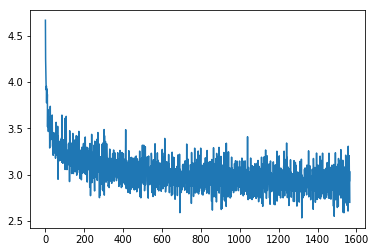

In [22]:
with train_g.as_default():
    loss_log = train()
    plt.plot(loss_log)

In [10]:
eval_g = tf.Graph()

In [11]:
def build_eval_graph(inputs):
    
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        embedding = tf.concat([tf.zeros([1, num_units]), 
                               tf.get_variable('embedding', shape=[vocab_size - 1, num_units])], axis=0)
                
        lstm_cell = MyLSTMCell(num_units, 'lstm_cell')

        def _cond(i, *args):
            return tf.less(i, 100)

        def _body(i, input_seq, state):

            this_token = tf.to_int32(input_seq[:, i])
            embed = tf.nn.embedding_lookup(embedding, this_token, 'embedding_layer')            
            output, next_state = lstm_cell(embed, state)
            logits = tf.layers.dense(output, vocab_size, activation=tf.nn.relu, name='final_dense', reuse=tf.AUTO_REUSE)

            next_token = tf.argmax(logits, axis=-1, output_type=tf.int32)
            next_seq = tf.concat([input_seq[:, :(i + 1)], tf.expand_dims(next_token, -1)], axis=1)            
            next_i = tf.add(i, 1)

            return next_i, next_seq, next_state
        
        batch_size = tf.shape(inputs)[0]
        initial_state = [tf.constant(0), inputs, lstm_cell.zero_state(batch_size)]
        
        with tf.variable_scope('rnn', reuse=tf.AUTO_REUSE):
            _, output_seq, _ = tf.while_loop(cond = _cond,
                                             body = _body, 
                                             shape_invariants=[tf.TensorShape([]), 
                                                               tf.TensorShape([None, None]), 
                                                               LstmStates(
                                                                   c_state=tf.TensorShape([None, num_units]), 
                                                                   h_state=tf.TensorShape([None, num_units]))],
                                             loop_vars= initial_state,
                                             parallel_iterations=1, 
                                             back_prop=False)

        return output_seq

In [14]:
with eval_g.as_default():
    sess = tf.Session()
    inputs = tf.placeholder(tf.int32, shape=[1, 1])
    output_seq = build_eval_graph(inputs)
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, '/home/slayer/Tensorflow/dev_day_ckpt/ckpt_temp')    

INFO:tensorflow:Restoring parameters from /home/slayer/Tensorflow/dev_day_ckpt/ckpt_temp


In [53]:
def get_result(start_token):
    return "".join([int2word.get(x) for x in sess.run(output_seq, feed_dict={inputs: [[word2int.get(start_token)]]})[0]]).split('<EOS>')[0].split('<PAD>')[0]

### 학습된 모델을 바탕으로 모델이 생성하는 단어는 어떨까요 ?

In [61]:
print("토지 AI ver\n")
for _ in range(100):
    print (get_result(random.choice(use_words)))

토지 AI ver

푸는 것이 아니었다. 그러나 그것은 그 일이 아니었다. 그러나 그것은 그
떡을 거 아니요? 그 말이 어디 가지고 왔다고 이 사람이 우리 아이
할 수 없었다. 그러나 그것은 그 일에 대해서는 이 나라 그 일을 모리고
만 하지 않고 말했다. 그러나 그것은 그 일에 대해서는 이미 이 사람이
흔들리고 다니는 것이 아니었다. 그러나 그것은 그 일이 아니었다. 그러나
개 가지고 말이야. 그 사람들 이 사람아, 그 사람들 그 사람 아니가.
경우는 그 말이 아니었다. 그러나 그것은 그 일이 아니었다. 그러나 그
옆에 가서 지나가는 것이 아니었다. 그러나 그것은 그 일이 아니었다. 그러나
번 들어가는 것이었다. 그러나 그것은 그 일에 대해서는 이미 이 사람이
란 말이요. 그 사람들 이 사람이 어디 가고 저 말 하믄 못 가는 기이
단 말이다. 그러나 그것은 그 일본 여자들의 모이를 하고 이 사람이 어디
염치를 지어 보이는 것이다. 그러나 그것은 그 말이 아니었다. 그러나 그것은
얻어 왔는데 그 사람들 이 사람아, 그 사람들 우리 조상들이 그런 말
겉은 사람들이 모두 그 사람 아니믄 그 말이 아니가. 그 사람들 우리 
물어보고 서 일이 없었다. 그러나 그것은 그 일이 아니었다. 그러나 그것은
객집 주인이 그 사람이 그런 것 같은데 그것은 그 말 아니가. 그러나
, 아무리 세상에 이 사람이 없어도 살아 기고 살아 기
순간 그 자신의 말이 나왔다. 그리고 그 말에 대한 의식에 가서 사라지고
육신이 나는 것이 아니었다. 그러나 그것은 그 일이 아니었다. 그러나
쉬었다. 그러나 그것은 그 말이 아니었다. 그러나 그것은 그 일이 아니었다.
공부도 하고 그 말이 아니라 하더라도 그 사람들 우리 조용하는 그 사람들
심정이 없는 것이 아니었다. 그러나 그것은 그 일이 아니었다. 그러나
틀림없는 일이었다. 그러나 그것은 그 일이 아니었다. 그러나 그것은 이
목소리는 아니었다. 그러나 그것은 그 말이 아니었다. 그러나 그것은 그
령이 없는 것이 아니었다. 그러나 그것은 그 일이